In [1]:
import os
import gym
import numpy as np
import pickle
from livelossplot import PlotLosses
from collections import deque

from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from envs.GraphEnv.impnode import ImpnodeEnv
import DQN_agent

In [4]:
# to initialize the replay buffer with some random interactions

def fill_memory(env, agent):
    for _ in range(NUM_MEM_FILL_EPS):
        done = False
        state, info = env.reset()

        while not done:
            action = env.action_space.sample(mask=info['node_action_mask']) # samples random action
            next_state, reward, done, truncated, info = env.step(action)
            agent.memory.store(state=state, action=action, next_state=next_state, reward=reward, done=done)

In [5]:
# trains the agent and plots the associated moving average rewards and epsilon values in real-time

def train_loop(env, agent, results_basepath):

    liveloss = PlotLosses()
    logs = {}

    last_100_rewards = deque([], maxlen=100)

    reward_history = []
    epsilon_history = []

    step_cnt = 0
    best_score = -np.inf

    for ep_cnt in range(NUM_TRAIN_EPS):

        logs['train epsilon'] = agent.epsilon # to plot current epsilon value

        done = False
        state, info = env.reset()
        ep_score = 0
        while not done:
            action = agent.select_action(state)
            next_state, reward, done, truncated, info = env.step(action)

            if step_cnt >= 5:
                agent.memory.store(state=state, action=action, next_state=next_state, reward=reward, done=done)
                agent.learn(BATCHSIZE)

                if step_cnt % UPDATE_FREQUENCY == 0:
                    agent.update_target_net()

            state = next_state
            ep_score += reward
            step_cnt += 1

        agent.update_epsilon()

        last_100_rewards.append(ep_score)
        current_avg_score = np.mean(last_100_rewards) # get average of last 100 scores
        logs['train avg score'] = current_avg_score

        reward_history.append(ep_score)
        epsilon_history.append(logs['train epsilon'])

        if current_avg_score >= best_score:
            agent.save_model('{}/dqn_model'.format(results_basepath))
            best_score = current_avg_score

        # update the plots in real-time
        liveloss.update(logs)
        liveloss.send()

    # store the reward and epsilon history that was tracked while running locally

    with open('{}/train_reward_history.pkl'.format(results_basepath), 'wb') as f:
        pickle.dump(reward_history, f)

    with open('{}/train_epsilon_history.pkl'.format(results_basepath), 'wb') as f:
        pickle.dump(epsilon_history, f)

In [6]:
# variables for training the agent

NUM_TRAIN_EPS = 1000000 #1000 number training episodes to run
NUM_MEM_FILL_EPS = 1000 #10 number of episodes to run to initialize the memory

DISCOUNT = 0.99 # gamma used for computing return

BATCHSIZE = 64 # number of transitions to sample from replay buffer for each learn step
MEMORY_CAPACITY = 500000  # size of the memory buffer
UPDATE_FREQUENCY = 1000 # number of interactions after which the target buffer is updated

EPS_MAX = 1.0 # initial epsilon value
EPS_MIN = 0.05 # final epsilon value
EPS_STEP = 10000 # amount by which epsilon is decayed at each episode

LR = 0.0001 # learning rate for the network

In [7]:
# create folder for storing the model and other files
results_basepath_train = "results/traineps{}_epsmax{}_epsmin{}_epsstep{}_batchsize{}_treps{}_memeps{}_memcap{}_gseed{}".format(
                                                                                                NUM_TRAIN_EPS,
                                                                                                EPS_MAX,
                                                                                                EPS_MIN,
                                                                                                EPS_STEP,
                                                                                                BATCHSIZE,
                                                                                                NUM_TRAIN_EPS,
                                                                                                NUM_MEM_FILL_EPS,
                                                                                                MEMORY_CAPACITY,
                                                                                                False)
os.makedirs(results_basepath_train, exist_ok=True)

seed = None
env_train = ImpnodeEnv(ba_edges = 4,max_removed_nodes = 3, seed=seed, render_option=False, train_mode=True)



In [8]:
# create the dqn_agent
dqn_agent_train = DQN_agent.DQNAgent(device,
                                     #env_train.observation_space.shape[0],
                                     5,
                                     env_train.action_space.n,
                                     discount=DISCOUNT,
                                     eps_max=EPS_MAX,
                                     eps_min=EPS_MIN,
                                     eps_step=EPS_STEP,
                                     memory_capacity=MEMORY_CAPACITY,
                                     lr=LR,
                                     train_mode=True)



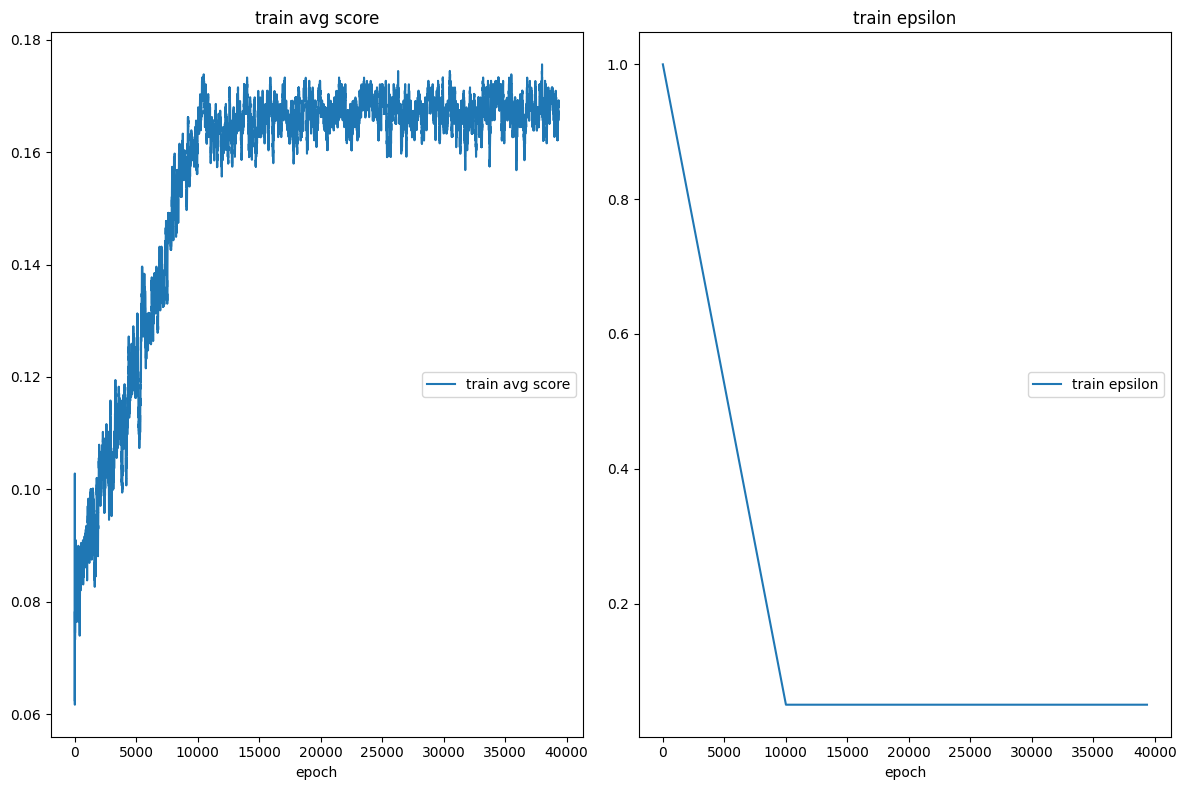

train avg score
	train avg score  	 (min:    0.062, max:    0.176, cur:    0.169)
train epsilon
	train epsilon    	 (min:    0.050, max:    1.000, cur:    0.050)


KeyboardInterrupt: 

In [9]:
# initialise the memory
fill_memory(env_train, dqn_agent_train)

# train the agent
train_loop(env_train, dqn_agent_train, results_basepath_train)


In [107]:
# tests the agent through interactions with the environment and plots the associated rewards in real-time

def test_loop(env, agent, results_basepath):
    liveloss = PlotLosses()
    logs = {}

    reward_history = []
    actions = []
    for ep in range(NUM_TEST_EPS):
        ep_score = 0
        done = False
        state, info = env.reset(ep)
        while not done:
            action = agent.select_action(state)
            actions.append(action)
            next_state, reward, done, truncated, _ = env.step(action)
            #ep_score += reward
            state = next_state

        # track reward history only while running locally

            reward_history.append(reward)

        # update the plot in real-time
            logs['test score'] = reward
            liveloss.update(logs)
            liveloss.send()
    return actions

    # store the reward that was tracked while running locally

    with open('{}/test_reward_history.pkl'.format(results_basepath), 'wb') as f:
        pickle.dump(reward_history, f)

In [108]:
# variables for testing the agent
# location where the model is stored and the name of the associated environment

RESULTS_BASEPATH_TEST = 'results/traineps1000000_epsmax1.0_epsmin0.05_epsstep10000_batchsize64_treps1000000_memeps1000_memcap500000_gseedFalse'

NUM_TEST_EPS = 1 # number of test episodes to run

In [112]:
# create test environment and set associated seed

seed = 8858
env_test = ImpnodeEnv(ba_edges = 4,max_removed_nodes = 10, seed=seed, render_option=False, data=False, train_mode=False)

# create the dqn agent with the stored weights
dqn_agent_test = DQN_agent.DQNAgent(device=device,
                          state_size=5,#env_test.observation_space.shape[0],
                          action_size=env_test.action_space.n,
                          discount=0.0,
                          eps_max=0.0,
                          eps_min=0.0,
                          eps_step=0.0,
                          memory_capacity=0,
                          train_mode=False)
dqn_agent_test.load_model('{}/dqn_model'.format(RESULTS_BASEPATH_TEST))



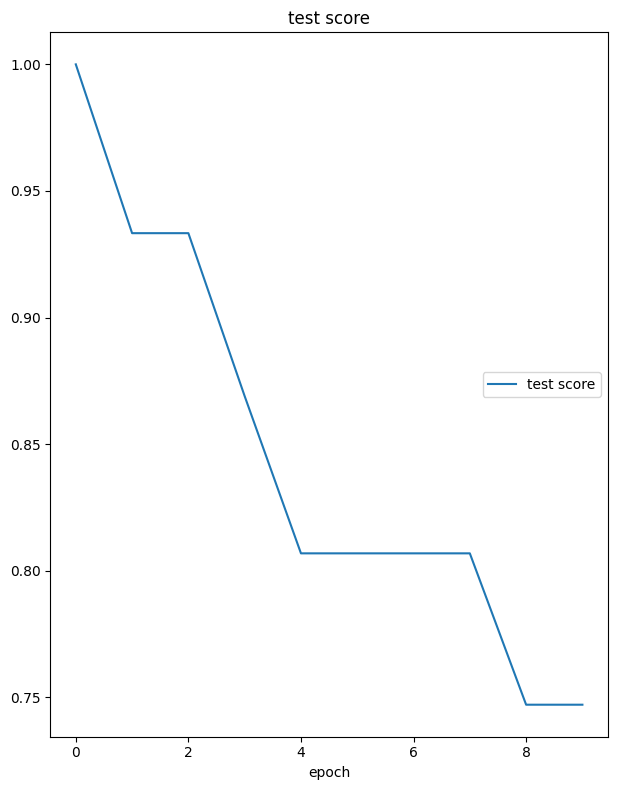

test score
	test score       	 (min:    0.747, max:    1.000, cur:    0.747)


In [113]:
# test the agent
actions = test_loop(env=env_test,
          agent=dqn_agent_test,
          results_basepath=RESULTS_BASEPATH_TEST)

In [114]:
actions

[12, 20, 1, 14, 15, 10, 20, 1, 10, 15]

In [87]:
import networkx as nx

In [89]:
graph = nx.barabasi_albert_graph(30, 4, seed)
pos = nx.spring_layout(graph)